# **Forecasting Currency Exchange Rates Using OpenBB Historical Data**

### **Description**
This notebook demonstrates how to predict future movements in currency exchange rates using using OpenBB's historical data. This notebook builds different forecasting model capable of analyzing trends in currency pairs such as USD/EUR, enabling data-driven predictions for future rates. The models evaluates risk and potential returns, providing valuable insights for traders, investors, and financial analysts.



---


### Author
[![Author Profile](https://img.shields.io/badge/Manish-k723-Color?style=flat&logo=github)](https://github.com/Manish-k723)


[![Open currencyExchangeRateForecasting.ipynb with Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1KCq_z-Td-G4hoA5eglJ0vASimn1LevLY?usp=share_link)

If you are running this notebook in Colab, you can run the following command to install the OpenBB Platform:

```python
!pip install openbb
```

In [16]:
# !pip install openbb -q #uncommment if you are in google colab
!pip install pmdarima -q

In [17]:
from openbb import obb  # Fetches historical forex data from OpenBB
import pandas as pd  # Data manipulation and analysis
import numpy as np  # For numerical computations
import matplotlib.pyplot as plt  # Data visualization
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error  # Evaluation of model performance (e.g., MSE)
from sklearn.preprocessing import MinMaxScaler  # Data normalization (scaling values)
from statsmodels.tsa.statespace.sarimax import SARIMAX  # Seasonal ARIMA forecasting model
from statsmodels.tsa.holtwinters import ExponentialSmoothing  # Exponential smoothing for time-series
import pmdarima as pm  # Auto-ARIMA for automatic ARIMA parameter selection
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout  # LSTM neural network layers for time-series data

# **Loading Data**
This cell fetches historical exchange rate data for the EUR/USD pair using the yfinance provider, choose the provider accordingly.

Please Refer [Yfinance](https://pypi.org/project/yfinance/) documenation for list of currency exchange symbols.

In [18]:
# Fetching historical data for the EUR/USD pair using the yfinance provider
start_date = '1991-01-01'
end_date = '2024-01-01'

# Since yfinance uses "EURUSD=X", we'll use that
forex_df = obb.equity.price.historical(symbol="EURUSD=X", provider="yfinance", start_date=start_date, end_date=end_date).to_df()

forex_df.sample(5)

,open,high,low,close,volume,split_ratio,dividend
date,,,,,,,
2012-11-19,1.275998,1.281851,1.274746,1.275950,0,0.0,0.0
2008-03-20,1.564089,1.564089,1.540310,1.544211,0,0.0,0.0
2010-06-01,1.228803,1.233898,1.211504,1.223301,0,0.0,0.0
2010-09-08,1.267893,1.276194,1.266416,1.267797,0,0.0,0.0
2017-05-30,1.112941,1.120160,1.111074,1.112904,0,0.0,0.0


# **Data Preprocessing**

In [19]:
forex_df.index = pd.to_datetime(forex_df.index)

forex_df = forex_df.asfreq('D')  # Resamples the data to a daily frequency ('D' stands for days), ensuring data is indexed daily

forex_df.ffill(inplace=True) # Forward fills missing values to fill gaps in the time series with the last available value

In [20]:
print(forex_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7337 entries, 2003-12-01 to 2024-01-01
Freq: D
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open         7337 non-null   float64
 1   high         7337 non-null   float64
 2   low          7337 non-null   float64
 3   close        7337 non-null   float64
 4   volume       7337 non-null   float64
 5   split_ratio  7337 non-null   float64
 6   dividend     7337 non-null   float64
dtypes: float64(7)
memory usage: 458.6 KB
None


In [21]:
# Split the data, keeping 20% of it for testing
train_size = int(len(forex_df) * 0.8)
train_data, test_data = forex_df['close'][:train_size], forex_df['close'][train_size:]

print(f"Training data: {len(train_data)} rows")
print(f"Testing data: {len(test_data)} rows")

Training data: 5869 rows
Testing data: 1468 rows


# **Model Training & Prediction**

In this section, we focus on time-series forecasting, which differs from traditional machine learning tasks. Unlike predicting a single output variable, time-series models aim to predict future values based on historical data, considering the sequential nature of the data. This is particularly important for predicting currency exchange rates, where trends, seasonality, and past values heavily influence future movements.

# **ARIMA Model**

We will start by using the ARIMA (AutoRegressive Integrated Moving Average) model for time-series forecasting. ARIMA is one of the most popular models for time-series analysis, as it combines three components:

1. AR (AutoRegressive): Uses past values to predict future ones.
2. I (Integrated): Makes the series stationary by differencing it.
3. MA (Moving Average): Models the error terms from previous time steps.

This model is ideal for capturing the trends and patterns in the currency exchange data. Let’s train and evaluate it on our dataset.

In [22]:
%%time
auto_arima_model = pm.auto_arima(train_data, seasonal=False, stepwise=True, suppress_warnings=True)
arima_predictions = auto_arima_model.predict(n_periods=len(test_data))
print(auto_arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5869
Model:               SARIMAX(2, 1, 3)   Log Likelihood               19709.279
Date:                Sun, 06 Oct 2024   AIC                         -39406.558
Time:                        09:24:51   BIC                         -39366.494
Sample:                    12-01-2003   HQIC                        -39392.629
                         - 12-25-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5440      0.123      4.435      0.000       0.304       0.784
ar.L2         -0.5804      0.101     -5.747      0.000      -0.778      -0.382
ma.L1         -0.7656      0.123     -6.247      0.0

# **SARIMAX Model**
Next, we will explore the SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous factors) model for forecasting. SARIMAX is an extension of the ARIMA model that incorporates seasonality and exogenous variables (optional external factors) into the prediction process.

1. Seasonality: Captures repeating patterns over a fixed period (e.g., weekly or monthly cycles).
2. Exogenous Variables (X): Allows the model to include additional factors that may influence the target variable (optional).

SARIMAX is particularly useful when dealing with time-series data that exhibits periodic fluctuations, making it well-suited for forecasting currency exchange rates where trends may repeat over time. Let’s apply SARIMAX to our dataset.

In [23]:
%%time
sarimax_model = SARIMAX(train_data,
                       order=(5, 1, 0),  # non-seasonal order
                       seasonal_order=(1, 1, 1, 12),  # seasonal order: parameters tuning is required
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarimax_fit = sarimax_model.fit(disp=False)
sarimax_predictions = sarimax_fit.forecast(steps=len(test_data))

CPU times: user 26 s, sys: 425 ms, total: 26.4 s
Wall time: 26.5 s


# **Exponential Smoothing**
We will also use the Exponential Smoothing technique for time-series forecasting. Unlike ARIMA and SARIMAX, this method places greater emphasis on more recent observations, making it useful for capturing short-term trends. Exponential smoothing can model various components of time series data, such as:

1. Level: The baseline value of the series.
2. Trend: The overall direction of the series.
3. Seasonality: The repeating short-term patterns.

This method is particularly effective for forecasting time-series data with trends and seasonality, making it suitable for currency exchange rate prediction, where both short- and long-term movements need to be captured.

In [24]:
%%time
exp_smooth_model = ExponentialSmoothing(train_data, trend='add', seasonal='add', seasonal_periods=12)
exp_smooth_fit = exp_smooth_model.fit()

# Predict using Exponential Smoothing
exp_smooth_predictions = exp_smooth_fit.forecast(steps=len(test_data))

CPU times: user 950 ms, sys: 5.11 ms, total: 955 ms
Wall time: 955 ms


# **LSTM Model**
Finally, we will employ a Long Short-Term Memory (LSTM) model, a type of recurrent neural network (RNN) specifically designed to handle sequential data like time series. LSTMs excel at capturing long-term dependencies in data by using memory cells that can retain information over extended time periods, which makes them well-suited for tasks where past values influence future ones, such as currency exchange rate prediction.

LSTMs are particularly powerful for modeling complex, non-linear relationships in time series data, making them ideal for forecasting in dynamic environments like financial markets, where historical patterns may vary in unexpected ways.

In [25]:
%%time
# Step 1: Data Preparation

# Scale the close prices of train_data and test_data (Series)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data.values.reshape(-1, 1))
scaled_test_data = scaler.transform(test_data.values.reshape(-1, 1))

# Creating dataset for LSTM from train_data
X_train, y_train = [], []
for i in range(60, len(scaled_train_data)):
    X_train.append(scaled_train_data[i-60:i, 0])  # Previous 60 days
    y_train.append(scaled_train_data[i, 0])  # Current day
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# Step 2: Build and Compile LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 3: Train the Model on the training data
model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1)

# Step 4: Preparing the test_data for making predictions

# Creating the test data sequences (just like we did for train_data)
X_test = []
for i in range(60, len(scaled_test_data)):
    X_test.append(scaled_test_data[i-60:i, 0])  # Previous 60 days
X_test = np.array(X_test)

# Reshaping for LSTM
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Step 5: Make Predictions on test_data
lstm_predictions = model.predict(X_test)

# Inverse scaling to get actual values for predictions
lstm_predictions = scaler.inverse_transform(lstm_predictions)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0317
Epoch 2/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0023
Epoch 3/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0021
Epoch 4/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0018
Epoch 5/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018
Epoch 6/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0016
Epoch 7/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0015
Epoch 8/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0015
Epoch 9/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0014
Epoch 10/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0014
Epoch 11/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0013
Epoch 12/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0012
Epoch 13/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0012
Epoch 14/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0012
Epoch 15/25
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.001

In [26]:
comparison_df = test_data.reset_index()
comparison_df['arima_predictions'] = arima_predictions.reset_index(drop=True)
comparison_df['sarimax_predictions'] = sarimax_predictions.reset_index(drop=True)
comparison_df['exp_smooth_predictions'] = exp_smooth_predictions.reset_index(drop=True)
comparison_df['lstm_predictions'] = np.nan
comparison_df.loc[60:, 'lstm_predictions'] = lstm_predictions.flatten()
comparison_df.sample(10)

,date,close,arima_predictions,sarimax_predictions,exp_smooth_predictions,lstm_predictions
1450,2023-12-15,1.099360,1.1092,1.079308,1.084464,1.083688
757,2022-01-21,1.131375,1.1092,1.093533,1.096215,1.140905
937,2022-07-20,1.023133,1.1092,1.089840,1.093168,1.011417
595,2021-08-12,1.174190,1.1092,1.097344,1.099435,1.177916
754,2022-01-18,1.141057,1.1092,1.093588,1.096244,1.147120
196,2020-07-09,1.133915,1.1092,1.106155,1.106816,1.129479
164,2020-06-07,1.133787,1.1092,1.106427,1.106955,1.129300
623,2021-09-09,1.181910,1.1092,1.096303,1.098480,1.188914
397,2021-01-26,1.214624,1.1092,1.100919,1.102308,1.217295
1412,2023-11-07,1.072156,1.1092,1.080822,1.085831,1.067676


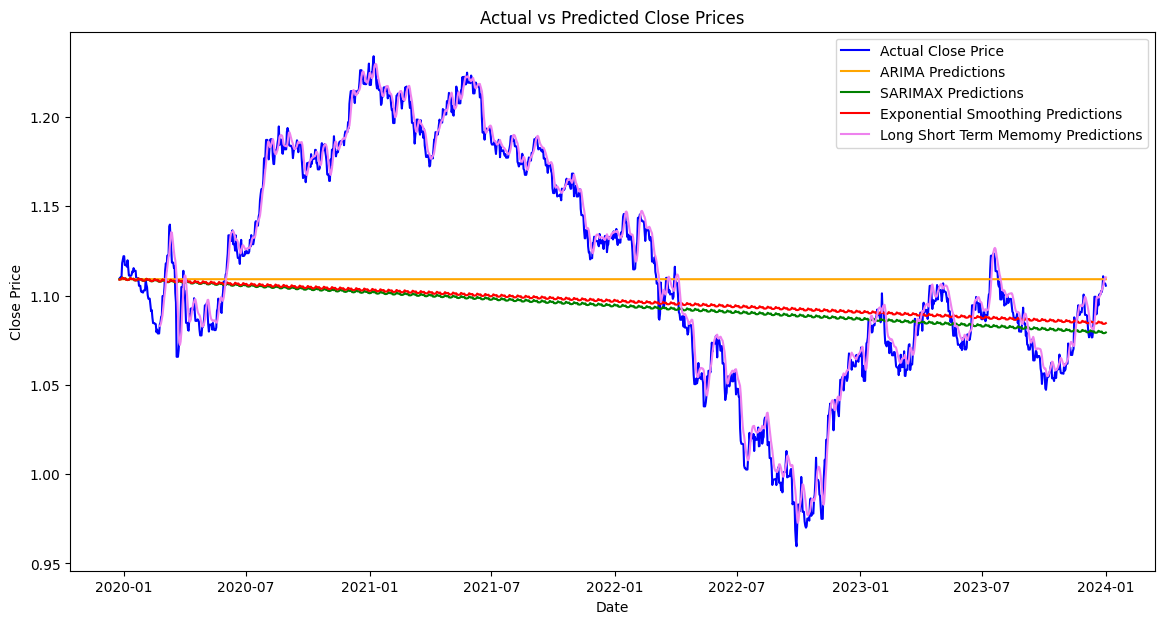

In [27]:
# Plotting the actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['date'], comparison_df['close'], label='Actual Close Price', color='blue')
plt.plot(comparison_df['date'], comparison_df['arima_predictions'], label='ARIMA Predictions', color='orange')
plt.plot(comparison_df['date'], comparison_df['sarimax_predictions'], label='SARIMAX Predictions', color='green')
plt.plot(comparison_df['date'], comparison_df['exp_smooth_predictions'], label='Exponential Smoothing Predictions', color='red')
plt.plot(comparison_df['date'], comparison_df['lstm_predictions'], label='Long Short Term Memomy Predictions', color='violet')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

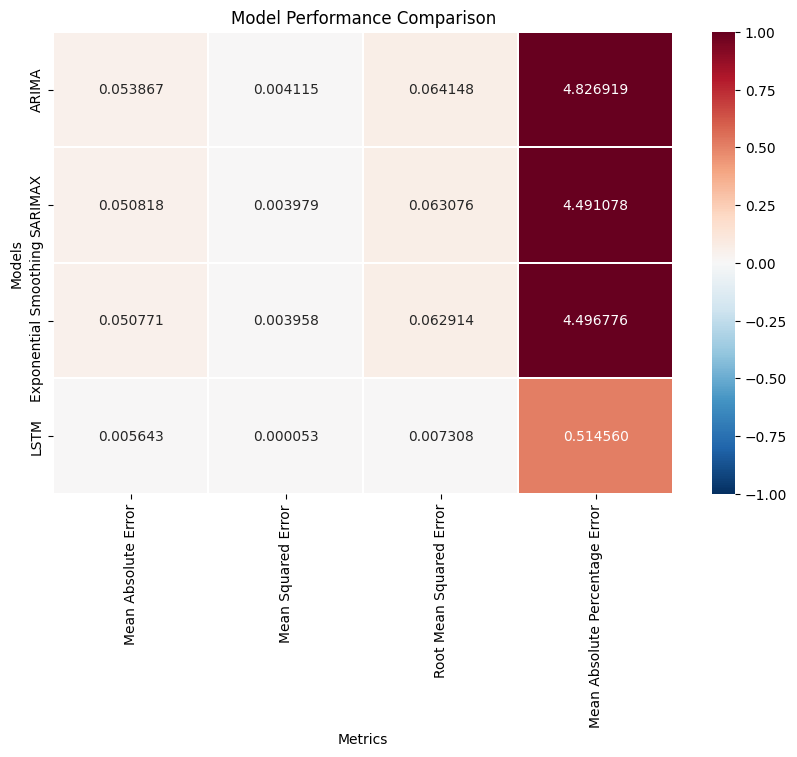

In [28]:
# Calculate errors for each prediction method
metrics = {}

# Define a function to calculate metrics
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = mse ** 0.5
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mae, mse, rmse, mape

# Get actual values
actual_values = comparison_df['close'].values

# Dropping rows where any of the predictions are NaN for cleaning
comparison_df_clean = comparison_df.dropna(subset=['arima_predictions', 'sarimax_predictions', 'exp_smooth_predictions', 'lstm_predictions'])

# Get the cleaned actual and predicted values
actual_values_clean = comparison_df_clean['close'].values
arima_predictions_clean = comparison_df_clean['arima_predictions'].values
sarimax_predictions_clean = comparison_df_clean['sarimax_predictions'].values
exp_smooth_predictions_clean = comparison_df_clean['exp_smooth_predictions'].values
lstm_predictions_clean = comparison_df_clean['lstm_predictions'].values

# Calculate metrics for each prediction method
metrics['ARIMA'] = calculate_metrics(actual_values_clean, arima_predictions_clean)
metrics['SARIMAX'] = calculate_metrics(actual_values_clean, sarimax_predictions_clean)
metrics['Exponential Smoothing'] = calculate_metrics(actual_values_clean, exp_smooth_predictions_clean)
metrics['LSTM'] = calculate_metrics(actual_values_clean, lstm_predictions_clean)

# Create a summary DataFrame
metrics_df = pd.DataFrame(metrics, index=['MAE', 'MSE', 'RMSE', 'MAPE']).T
metrics_df.columns = ['Mean Absolute Error', 'Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Percentage Error']

plt.figure(figsize=(10, 6))

# Create a heatmap
sns.heatmap(metrics_df, annot=True, fmt='.6f', linewidths=0.1, vmax=1.0, vmin=-1.0, cbar=True, cmap=plt.cm.RdBu_r, linecolor='white')

# Adding titles and labels
plt.title('Model Performance Comparison')
plt.xlabel('Metrics')
plt.ylabel('Models')

# Show the plot
plt.show()

# **Hyperparameter Tuning of SARIMAX**

In this section, we conduct hyperparameter tuning for the SARIMAX model to find the optimal combination of parameters that minimizes the Akaike Information Criterion (AIC). The AIC is a measure of the goodness of fit of a statistical model, and lower values indicate a better fit.


##### **Note: Hyperparameter tuning step consumes a lot of time(more than a hour), Beneath provided is just sample code for usage if you have enough resourse and time then only try it after uncommenting.**




In [29]:
# # Define the p, d, q parameters to take any value between 0 and 2
#import itertools
# p = d = q = range(0, 3)

# # Define the seasonal parameters (P, D, Q, s)
# P = D = Q = range(0, 2)
# seasonal_period = [7, 14, 21]  # Seasonal period, e.g., 12 for monthly data

# # Create a list of all possible combinations of p, d, q for non-seasonal and seasonal terms
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = list(itertools.product(P, D, Q, seasonal_period))

# # Search for the best combination of parameters
# best_aic = np.inf
# best_pdq = None
# best_seasonal_pdq = None
# best_model = None

# for param in pdq:
#     for seasonal_param in seasonal_pdq:
#         try:
#             # Fit the SARIMAX model with the given parameters
#             model = SARIMAX(train_data,
#                             order=param,
#                             seasonal_order=seasonal_param,
#                             enforce_stationarity=False,
#                             enforce_invertibility=False)
#             results = model.fit(disp=False)

#             # Keep track of the best model based on AIC
#             if results.aic < best_aic:
#                 best_aic = results.aic
#                 best_pdq = param
#                 best_seasonal_pdq = seasonal_param
#                 best_model = results

#         except Exception as e:
#             continue

# print(f"Best SARIMAX model: ARIMA{best_pdq} x {best_seasonal_pdq}12 - AIC: {best_aic}")

In [30]:
# sarima_predictions = best_model.forecast(steps=len(test_data))

# # Compute the RMSE
# rmse = np.sqrt(mean_squared_error(test_data, sarima_predictions))
# print(f"SARIMAX Test RMSE: {rmse}")